In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F

/cluster/courses/deep_learning/jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os

root_dir = 'TODO'


In [3]:
from IPython import get_ipython
ipython = get_ipython()
ipython.run_line_magic("cd", root_dir)

/home/aoezkan/dl_proj


In [4]:
from utils.metrics import topk_acc, real_acc, AverageMeter
from utils.parsers import get_training_parser
from utils.optimizer import get_optimizer, get_scheduler, OPTIMIZERS_DICT, SCHEDULERS

from models.networks import get_model
from data_utils.data_stats import *

import matplotlib.pyplot as plt
import argparse
import time

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Assuming a single-GPU setup
    device_properties = torch.cuda.get_device_properties(device)

    total_memory = device_properties.total_memory
    allocated_memory = torch.cuda.memory_allocated(device)
    cached_memory = torch.cuda.memory_reserved(device)

    print(f"Total GPU Memory: {total_memory / 1e9} GB")
    print(f"Allocated Memory: {allocated_memory / 1e9} GB")
    print(f"Cached Memory: {cached_memory / 1e9} GB")
else:
    print("CUDA is not available.")

print(torch.version.cuda)

Total GPU Memory: 11.71488768 GB
Allocated Memory: 0.0 GB
Cached Memory: 0.0 GB
11.8


In [6]:
dataset = 'cifar10'                 # One of cifar10, cifar100, stl10, imagenet or imagenet21
architecture = 'B_12-Wi_1024'
data_resolution = 32                # Resolution of data as it is stored
crop_resolution = 64                # Resolution of fine-tuned model (64 for all models we provide)
# num_classes = CLASS_DICT[dataset]
# eval_batch_size = 1024
checkpoint = 'in21k_imagenet'

# bypass ing
num_classes = 1000
input_size = 64
model_mlp = get_model(architecture=architecture, resolution=input_size, num_classes=num_classes, checkpoint=checkpoint)
model_mlp.linear_out = nn.Linear(1024, 200)

model_full_path = os.path.join("checkpoints", "mlp_b12_wi1024_imagenet_bs128_tinyimagenet.t7")
checkpoint = torch.load(model_full_path, map_location=torch.device(device))

model_mlp = torch.nn.DataParallel(model_mlp)
model_mlp.load_state_dict(checkpoint['model'])
model_mlp = model_mlp.to(device)
model_mlp.eval()

Weights already downloaded
Load_state output <All keys matched successfully>


DataParallel(
  (module): BottleneckMLP(
    (linear_in): Linear(in_features=12288, out_features=1024, bias=True)
    (linear_out): Linear(in_features=1024, out_features=200, bias=True)
    (blocks): ModuleList(
      (0-11): 12 x BottleneckBlock(
        (block): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
    )
    (layernorms): ModuleList(
      (0-11): 12 x LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
  )
)

In [7]:
num_classes = 200
model_resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model_resnet.fc = torch.nn.Linear(model_resnet.fc.in_features, num_classes)

model_full_path = os.path.join("checkpoints", "ResNet18_TinyImageNet.t7")
checkpoint = torch.load(model_full_path, map_location=torch.device(device))

model_resnet = torch.nn.DataParallel(model_resnet)
model_resnet.load_state_dict(checkpoint['model'])
model_resnet = model_resnet.to(device)
model_resnet.eval()

Using cache found in /home/aoezkan/.cache/torch/hub/pytorch_vision_v0.10.0
/cluster/courses/deep_learning/jupyter/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cluster/courses/deep_learning/jupyter/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [8]:
timm_path = os.path.join(root_dir, "../pytorch-image-models/")
ipython.run_line_magic("cd", timm_path)
import timm
ipython.run_line_magic("cd", root_dir)

/home/aoezkan/pytorch-image-models
/home/aoezkan/dl_proj


In [9]:
model_vit = timm.create_model("vit_tiny_patch16_224", pretrained=True)
model_vit.head = nn.Linear(model_vit.head.in_features, 200) # tinyimagnet


model_full_path = os.path.join("checkpoints", "vit_tiny_patch16_224_unfrozen_tinyimagenet.t7")
checkpoint = torch.load(model_full_path, map_location=torch.device(device))

model_vit = torch.nn.DataParallel(model_vit)
model_vit.load_state_dict(checkpoint['model'])
model_vit = model_vit.to(device)
model_vit.eval()

DataParallel(
  (module): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='none')


In [19]:
import urllib
import ast

# The URL which has stored the categories of ImageNet
url_class = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'

# Load the classes and store them as a list
labels = []
for line in urllib.request.urlopen(url_class):
  txt = line.decode('utf-8')
  # Clean the string
  label = ''.join([i for i in txt if not i.isdigit() and i != ':' and i != ','])
  labels.append(label.strip())

print('We have', len(labels), 'classes')

# That's the Toucan label
true_label = 1
print(str(true_label) + '-th label is', labels[true_label])

We have 1000 classes
1-th label is 'goldfish Carassius auratus'


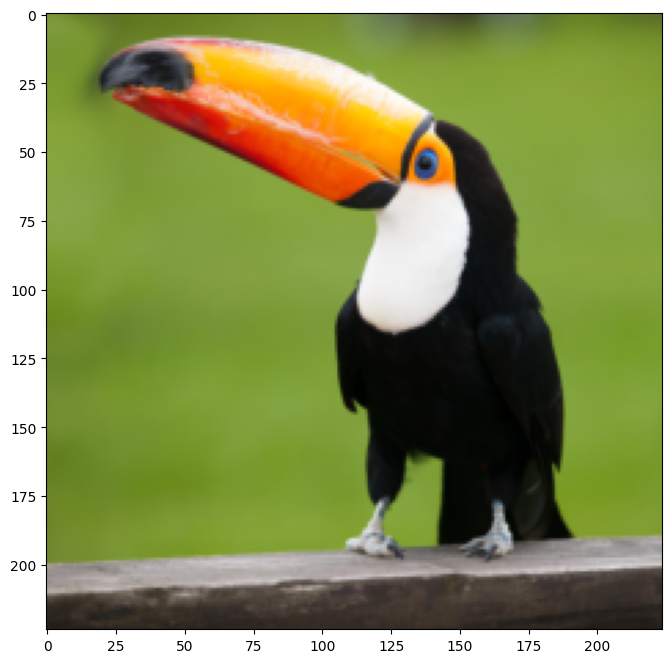

In [20]:
from PIL import Image
import requests
from torchvision import transforms
import matplotlib.pyplot as plt

# Download example image from website
url = 'https://user-images.githubusercontent.com/38691167/145074001-b81f53df-2075-4683-ab9b-c02dd53794a7.jpg'
img = Image.open(requests.get(url, stream=True).raw)

# Resize the image to ImageNet size
preprocess = transforms.Compose([
   transforms.Resize((224, 224)),
   transforms.ToTensor(),
])

x = preprocess(img)[None,:,:,:]
# Plot the image
plt.rcParams['figure.figsize'] = [8, 8]
plt.imshow(x[0].numpy().transpose(1,2,0))

In [5]:
# The mean and std of ImageNet samples
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

# Define a normalization function
def normalize(x):
  return (x - mean[None,:,None,None]) / std[None,:,None,None]

# Normalize the image (think of 'normalize' as a map between image space and network space)
x_norm = normalize(x)
# Get the logits of the model
logits = model(x_norm)
# Convert it to a 'hard' prediction
pred = torch.argmax(logits)
print('The image is a ', labels[pred])

The image is a  'toucan'


In [58]:
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

In [62]:
from torchvision.transforms.functional import gaussian_blur
from IPython.display import display, clear_output

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
import torchvision
from torchvision import transforms
from PytorchRevelio import PytorchRevelio
from utilities_PytorchRevelio import imagenet_labels

In [11]:
import torchvision.models as models
# model = models.resnet18(pretrained=True)
#model = torchvision.models.alexnet(pretrained=True)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))

Device: cuda:0


# WRAPPERS

In [13]:
class MLP_Wrapper(nn.Module):
    def __init__(self, model, input_size):
        super(MLP_Wrapper, self).__init__()
        self.model = model
        self.resize = transforms.Resize(input_size)

    def forward(self, x):
        x = x.flatten(1)
        x = self.model(x)
        return x

In [14]:
class Model_Wrapper(nn.Module):
    def __init__(self, model, input_size):
        super(Model_Wrapper, self).__init__()
        self.model = model
        self.resize = transforms.Resize(input_size)

    def forward(self, x):
        x = self.resize(x)
        x = self.model(x)
        return x

In [15]:
input_size = 64

model_mlp_wrap = MLP_Wrapper(model_mlp, input_size)
model_mlp_wrap = model_mlp_wrap.to(device)
model_mlp_wrap.eval()

MLP_Wrapper(
  (model): DataParallel(
    (module): BottleneckMLP(
      (linear_in): Linear(in_features=12288, out_features=1024, bias=True)
      (linear_out): Linear(in_features=1024, out_features=200, bias=True)
      (blocks): ModuleList(
        (0-11): 12 x BottleneckBlock(
          (block): Sequential(
            (0): Linear(in_features=1024, out_features=4096, bias=True)
            (1): GELU(approximate='none')
            (2): Linear(in_features=4096, out_features=1024, bias=True)
          )
        )
      )
      (layernorms): ModuleList(
        (0-11): 12 x LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (resize): Resize(size=64, interpolation=bilinear, max_size=None, antialias=warn)
)

In [16]:
input_size = 224

model_resnet_wrap = Model_Wrapper(model_resnet, input_size)
model_resnet_wrap = model_resnet_wrap.to(device)
model_resnet_wrap.eval()

Model_Wrapper(
  (model): DataParallel(
    (module): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): B

In [17]:
input_size = 224

model_vit_wrap = Model_Wrapper(model_vit, input_size)
model_vit_wrap = model_vit_wrap.to(device)
model_vit_wrap.eval()

model_vit_wrap

Model_Wrapper(
  (model): DataParallel(
    (module): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=192, out_features=576, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=192, out_features=192, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=19

In [18]:
# model = model_mlp_wrap
# model = model_resnet
# model = model_resnet

# OURS

In [19]:
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

In [20]:
import time
import numpy as np

In [22]:
from torchvision.transforms.functional import gaussian_blur
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

In [23]:
def gaussian_blur_channelwise(input_tensor, kernel_size, sigma):
    channels = 3
    blurred_channels = []
    for c in range(channels):
        blurred_channel = gaussian_blur(input_tensor[:, c:c+1, :, :], kernel_size=kernel_size, sigma=sigma)
        blurred_channels.append(blurred_channel)
    return torch.cat(blurred_channels, dim=1)

In [24]:
normalize = transforms.Normalize(mean, std)

def clamp_to_img(x):
  return torch.clamp(x, min=0., max=1.)

In [61]:
def activation_maximzation(model, label, lamb, alpha, iters, sigma=1, kernel_size=3, end_sigma=3, device="cpu"):
    image_res = 64
    image = torch.randn(1, 3, image_res, image_res).to(device)
    r = torch.rand_like(image).to(device)
    r.requires_grad_()
    
    for i in range(iters):
      preds = model(normalize(r))
      loss = preds[0,label] - lamb*(torch.norm(r,p=2))
      (-loss).backward()
    
      r.data -=  alpha * r.grad.data
      
      with torch.no_grad():
        r.data = gaussian_blur_channelwise(r, kernel_size, sigma)
        sigma*=0.99
        if sigma < end_sigma:
            sigma = end_sigma
        norms = torch.norm(r, dim=1, p=2)
        if device =='cpu':
            np_norms = norms.squeeze().numpy()
        else:
            np_norms = norms.squeeze().detach().cpu().numpy()
        # perc = np.percentile(np_norms, 0.001)
        # below_threshold = norms < perc
        # r.data[:, :, below_threshold.squeeze(0)] = 0
    
      # if i % 25 == 0:
      #     #display image
      #     image_np = clamp_to_img(r.detach())[0].permute(1, 2, 0).cpu().numpy()
      #     clear_output(wait=True)
      #     display(plt.gcf())
      #     print("iteration:", i)
      #     print("sigma:", sigma)
      #     plt.imshow(image_np)
      #     plt.axis('off')
      #     plt.show()
      #     time.sleep(0.5)

    image_np = clamp_to_img(r.detach())[0].permute(1, 2, 0).cpu().numpy()
    clear_output(wait=True)
    display(plt.gcf())
    print("iteration:", i)
    print("sigma:", sigma)
    plt.imshow(image_np)
    plt.axis('off')
    plt.show()

    
    out_image = r.detach()
    return out_image

<Figure size 800x800 with 0 Axes>

iteration: 975
sigma: 5


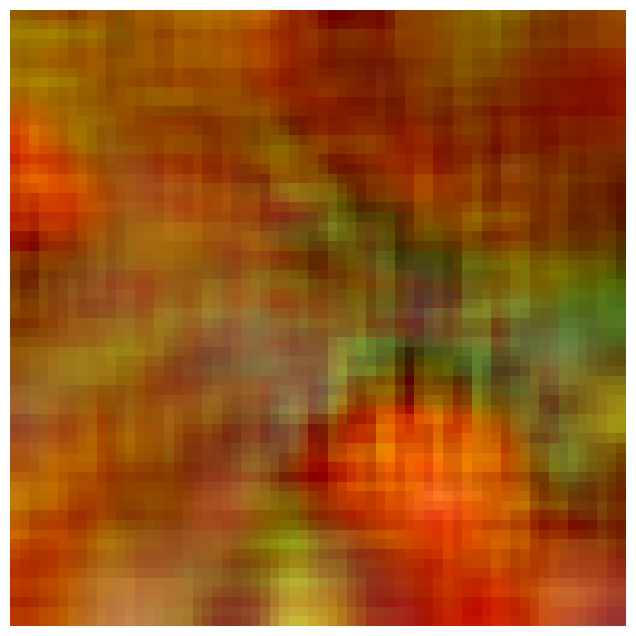

tensor([[[[ 0.5656,  0.5590,  0.5523,  ...,  0.5595,  0.5703,  0.5803],
          [ 0.5878,  0.5783,  0.5783,  ...,  0.5586,  0.5647,  0.5737],
          [ 0.6088,  0.6055,  0.6074,  ...,  0.5601,  0.5659,  0.5744],
          ...,
          [ 0.6613,  0.6462,  0.6500,  ...,  0.7081,  0.6729,  0.6599],
          [ 0.7085,  0.6933,  0.6948,  ...,  0.6787,  0.6461,  0.6393],
          [ 0.7174,  0.7027,  0.7059,  ...,  0.6568,  0.6232,  0.6177]],

         [[ 0.3605,  0.3517,  0.3217,  ...,  0.2781,  0.2884,  0.3045],
          [ 0.4424,  0.4306,  0.4165,  ...,  0.2617,  0.2653,  0.2762],
          [ 0.4841,  0.4801,  0.4805,  ...,  0.2609,  0.2585,  0.2628],
          ...,
          [ 0.1617,  0.1526,  0.1771,  ...,  0.2928,  0.2549,  0.2511],
          [ 0.2249,  0.2222,  0.2415,  ...,  0.2446,  0.2084,  0.2091],
          [ 0.2146,  0.2148,  0.2340,  ...,  0.2477,  0.2040,  0.2049]],

         [[-0.2120, -0.2169, -0.2160,  ..., -0.1840, -0.1744, -0.1672],
          [-0.1808, -0.1828, -

In [93]:
activation_maximzation(model_resnet_wrap, 199, lamb=0.1, alpha=0.001, iters=1000, sigma=13, kernel_size=7, end_sigma=5, device="cuda")

<Figure size 640x480 with 0 Axes>

iteration: 999
sigma: 5


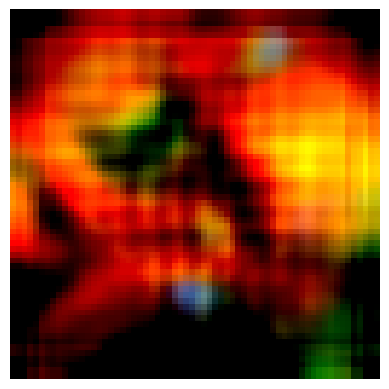

tensor([[[[-0.9514, -0.9099, -0.7379,  ..., -0.9880, -1.0959, -1.0789],
          [-0.9637, -0.9221, -0.7486,  ..., -0.9744, -1.0693, -1.0468],
          [-0.9596, -0.9152, -0.7321,  ..., -0.9642, -1.0450, -1.0209],
          ...,
          [-0.1024, -0.1370, -0.1381,  ..., -0.2989, -0.2956, -0.2633],
          [-0.0140, -0.0439, -0.0328,  ..., -0.1766, -0.1811, -0.1491],
          [-0.0199, -0.0485, -0.0331,  ..., -0.1718, -0.1788, -0.1467]],

         [[-1.3565, -1.3362, -1.1912,  ..., -1.0698, -1.0930, -1.0412],
          [-1.4312, -1.4066, -1.2577,  ..., -1.0904, -1.1106, -1.0597],
          [-1.5300, -1.5017, -1.3384,  ..., -1.1739, -1.1901, -1.1409],
          ...,
          [-0.6806, -0.7315, -0.7413,  ..., -0.1731, -0.1887, -0.1571],
          [-0.5294, -0.5736, -0.5741,  ..., -0.0606, -0.0930, -0.0651],
          [-0.5203, -0.5646, -0.5594,  ..., -0.0520, -0.0867, -0.0573]],

         [[-1.4057, -1.3965, -1.2813,  ..., -0.8072, -0.8102, -0.7601],
          [-1.4445, -1.4341, -

In [62]:
activation_maximzation(model_mlp_wrap, 199, lamb=0.0001, alpha=0.01, iters=1000, sigma=13, kernel_size=7, end_sigma=5, device="cuda")

<Figure size 800x800 with 0 Axes>

iteration: 975
sigma: 5


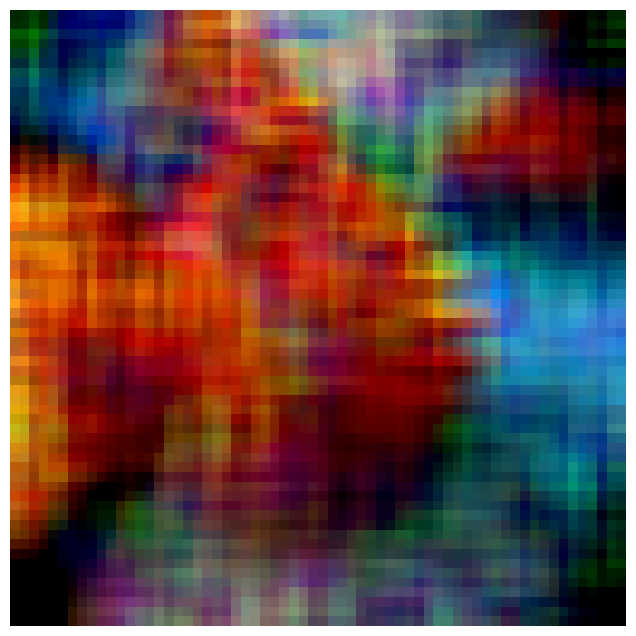

tensor([[[[-0.0862, -0.0959, -0.0718,  ..., -0.3016, -0.3641, -0.5321],
          [-0.1010, -0.1163, -0.0812,  ..., -0.2763, -0.3143, -0.4662],
          [-0.0453, -0.0805, -0.0297,  ..., -0.1614, -0.1492, -0.2660],
          ...,
          [-0.4468, -0.4616, -0.3853,  ..., -0.2235, -0.2353, -0.2510],
          [-0.4703, -0.4937, -0.3973,  ..., -0.1979, -0.2567, -0.2676],
          [-0.4802, -0.5046, -0.3994,  ..., -0.2085, -0.2743, -0.2796]],

         [[ 0.1320,  0.1511,  0.2400,  ...,  0.0198,  0.1376,  0.1314],
          [ 0.1571,  0.1726,  0.2768,  ...,  0.0577,  0.1701,  0.1952],
          [ 0.3315,  0.3302,  0.4406,  ..., -0.0240,  0.0822,  0.0714],
          ...,
          [-0.3110, -0.3085, -0.2085,  ..., -0.1023, -0.1368, -0.1766],
          [-0.3419, -0.3509, -0.2215,  ..., -0.0853, -0.1913, -0.2495],
          [-0.3363, -0.3397, -0.2038,  ..., -0.1027, -0.2324, -0.2878]],

         [[-0.4643, -0.3959, -0.3050,  ..., -0.5048, -0.5916, -0.5479],
          [-0.3414, -0.2820, -

In [102]:
activation_maximzation(model_vit_wrap, 199, lamb=0.0001, alpha=0.01, iters=1000, sigma=13, kernel_size=7, end_sigma=5, device="cuda")